In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import sxs
import qnmfits
import bgp_qnm_fits as bgp
from bgp_qnm_fits import (
    get_residuals,
    get_params,
    train_hyper_params,
    kernel_WN,
    kernel_GP,
)
import corner
import quaternionic
import spherical 
from scipy.signal import savgol_filter

In [2]:
def wfm_to_qnmfit(sim, zero_time=(2,2), transform=None):
    data_dict = {} 
    Mf = sim.metadata.remnant_mass
    chif = sim.metadata.remnant_dimensionless_spin
    chif1 = sim.metadata.reference_dimensionless_spin1
    chif2 = sim.metadata.reference_dimensionless_spin2
    h = sim.h
    for l in range(2, 8):
        for m in range(-l, l+1):
            if h.index(l, m) is not None:
                data_dict[(l, m)] = h.data[:, h.index(l, m)]
    times = h.t 

    global_peak_time = qnmfits.Custom(
                            times,
                            data_dict,
                            metadata={
                                "remnant_mass": Mf,
                                "remnant_dimensionless_spin": chif,
                            },
                            zero_time='norm',
                            transform=transform,
                        ).zero_time
    
    return qnmfits.Custom(
            times,
            data_dict,
            metadata={
                "remnant_mass": Mf,
                "remnant_dimensionless_spin": chif,
                "reference_dimensionless_spin1": chif1,
                "reference_dimensionless_spin2": chif2,
                "global_peak_time": global_peak_time,
            },
            transform=transform,
            zero_time=zero_time,
        )

check that this rotation is appropriate!

In [3]:
print(wf.metadata['reference_position1'])
print(wf.metadata['reference_position2'])

NameError: name 'wf' is not defined

In [4]:
def rotate_modes_x_to_z(wf_data, ellmax=7):
    """
    Rotate modes so that the +x direction is mapped to +z (fixed 90° rotation).
    Recomputes waveform.h in-place using the waveform.wigner.D API and returns the quaternion.
    """

    h = wf_data.copy() 

    rotvec = np.array([0.0, -1.0, 0.0]) * (np.pi / 2)
    R = quaternionic.array.from_axis_angle(rotvec)

    wigner_obj = spherical.Wigner(ellmax)
    D = wigner_obj.D(R)

    hp = {} 
    for l in range(2, ellmax + 1):
        for m in range(-l, l + 1):
            hp[l,m] = np.zeros_like(h[(l,m)])
            for mp in range(-l, l + 1):
                idx = wigner_obj.Dindex(l, mp, m)
                hp[l,m] += D[idx] * h[(l,mp)]

    return hp

In [5]:
def strain_to_news(times, data_dict):
    news_dict = {}
    for key in data_dict:
        news_dict[key] = np.gradient(data_dict[key], times)
    return news_dict

In [6]:
sim_id = "3991"
sim_main = wfm_to_qnmfit(sxs.load(f'SXS:BBH:{sim_id}/Lev3'), zero_time=(2,2))
sim_lower = wfm_to_qnmfit(sxs.load(f'SXS:BBH:{sim_id}/Lev2'), zero_time=(2,2))

Loading SXS simulations using latest tag 'v3.0.0', published at 2025-05-14T18:17:30Z.


In [7]:
sim_main_news = strain_to_news(sim_main.times, sim_main.h)
sim_lower_news = strain_to_news(sim_lower.times, sim_lower.h)

sim_main_news_z = rotate_modes_x_to_z(sim_main_news, ellmax=7)
sim_lower_news_z = rotate_modes_x_to_z(sim_lower_news, ellmax=7)

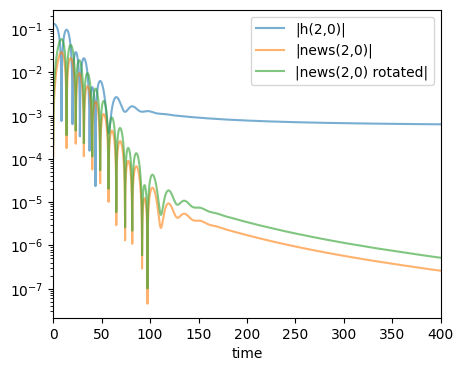

In [8]:
plt.figure(figsize=(5, 4))
plt.plot(sim_main.times, np.abs(sim_main.h[(2, 0)]), label='|h(2,0)|', alpha=0.6)
plt.plot(sim_main.times, np.abs(sim_main_news[(2, 0)]), label='|news(2,0)|', alpha=0.6)
plt.plot(sim_main.times, np.abs(sim_main_news_z[(2, 0)]), label='|news(2,0) rotated|', alpha=0.6)
plt.xlabel('time')
plt.legend()
plt.yscale('log')
plt.xlim(0, 400)
plt.show()

In [9]:
sim_main_new = qnmfits.Custom(
            sim_main.times,
            sim_main_news_z,
            metadata={
                "remnant_mass": sim_main.Mf,
                "remnant_dimensionless_spin": sim_main.chif,
            }
        )

sim_lower_new = qnmfits.Custom(
            sim_lower.times,
            sim_lower_news_z,
            metadata={
                "remnant_mass": sim_lower.Mf,
                "remnant_dimensionless_spin": sim_lower.chif,
            }
        )

### Get uncertainty estimate

In [10]:
RESIDUAL_BIG_START = -10
RESIDUAL_BIG_END = 310
TIME_STEP = 0.1

TRAINING_START_TIME = 0
TRAINING_RANGE = 200

SMOOTHNESS = 1e-3
TIME_SHIFT = 0 

INITIAL_PARAMS = [5.51806949954791]

HYPERPARAM_RULE_DICT = {
    "sigma_max": "multiply",
}

SIGMA_MAX_LOWER, SIGMA_MAX_UPPER = 1, 50
T_S_LOWER, T_S_UPPER = -20, 30
LENGTH_SCALE_LOWER, LENGTH_SCALE_UPPER = 0.1, 5
PERIOD_LOWER, PERIOD_UPPER = 0.1, 10

BOUNDS = [
    (SIGMA_MAX_LOWER, SIGMA_MAX_UPPER),
]


TRAINING_SPH_MODES = [
    (2, 2),
    (2, 1),
    (3, 3),
    (3, 2),
    (4, 4),
    (2, -2),
    (2, -1),
    (3, -3),
    (3, -2),
    (4, -4),
]

def get_hyperparams_WN(R_dict, param_dict):

    SIM_TRAINING_MODE_RULES_ALL = {sim_id: "ALL" for sim_id in R_dict.keys()}
    
    hyperparam_list, le, tuned_params = train_hyper_params(
        TRAINING_START_TIME,
        TRAINING_RANGE,
        TIME_STEP,
        INITIAL_PARAMS,
        BOUNDS,
        param_dict,
        R_dict,
        HYPERPARAM_RULE_DICT,
        kernel_WN,
        TRAINING_SPH_MODES,
        SIM_TRAINING_MODE_RULES_ALL,
    )

    return hyperparam_list, le, tuned_params

times = np.arange(
        RESIDUAL_BIG_START, RESIDUAL_BIG_END + RESIDUAL_BIG_START, TIME_STEP
    )
R_dict = {}
param_dict = {} 
mask_WN = (times >= TRAINING_START_TIME) & (times < TRAINING_START_TIME + TRAINING_RANGE)

R_lm_big = get_residuals(
                sim_main_new,
                sim_lower_new,
                RESIDUAL_BIG_START,
                RESIDUAL_BIG_END,
                dt=TIME_STEP,
            )

params_lm = get_params(
            R_lm_big,
            np.arange(RESIDUAL_BIG_START, RESIDUAL_BIG_START + RESIDUAL_BIG_END, TIME_STEP),
            sim_main_new.Mf,
            sim_main_new.chif_mag,
            SMOOTHNESS,
            TIME_SHIFT,
            data_type='strain',
        )

R_dict[sim_id] = {key: value[mask_WN] for key, value in R_lm_big.items()}
param_dict[sim_id] = params_lm 

hyperparam_list, le, tuned_params = get_hyperparams_WN(R_dict, param_dict)

print(tuned_params)

with open(f"tuned_params_WN_SXS.pkl", "wb") as f:
    pickle.dump(tuned_params, f)

Optimal parameters: {'sigma_max': 1.0} Log evidence: -647079.7691218816
Tuning parameters...
{'3991': {(2, -2): {'sigma_max': 1.3945375243980682e-07, 'A_max': 1.3945375243980682e-07, 'A_min_reg': 1.2354739778123364e-09, 't_s': 0, 'smoothness': 0.001, 'length_scale': 11.233407445261943, 'period': -16.803785712346993, 'length_scale_2': 11.233407445261943, 'period_2': -16.803785712346993, 'a': 0.5}, (2, -1): {'sigma_max': 4.395891446267319e-10, 'A_max': 4.395891446267319e-10, 'A_min_reg': 7.024124776295734e-11, 't_s': 0, 'smoothness': 0.001, 'length_scale': 11.233407336576633, 'period': -16.80378815136195, 'length_scale_2': 11.233407336576633, 'period_2': -16.80378815136195, 'a': 0.5}, (2, 0): {'sigma_max': 8.329316668020386e-06, 'A_max': 8.329316668020386e-06, 'A_min_reg': 2.6859987852186087e-08, 't_s': 0, 'smoothness': 0.001, 'length_scale': 11.233407227891263, 'period': 16.803790590376753, 'length_scale_2': 11.233407227891263, 'period_2': 16.803790590376753, 'a': 0.5}, (2, 1): {'sigma_

check it looks ok - it basically fixes to a tuning param of lam=1 because of the imaginary data but this is sufficient

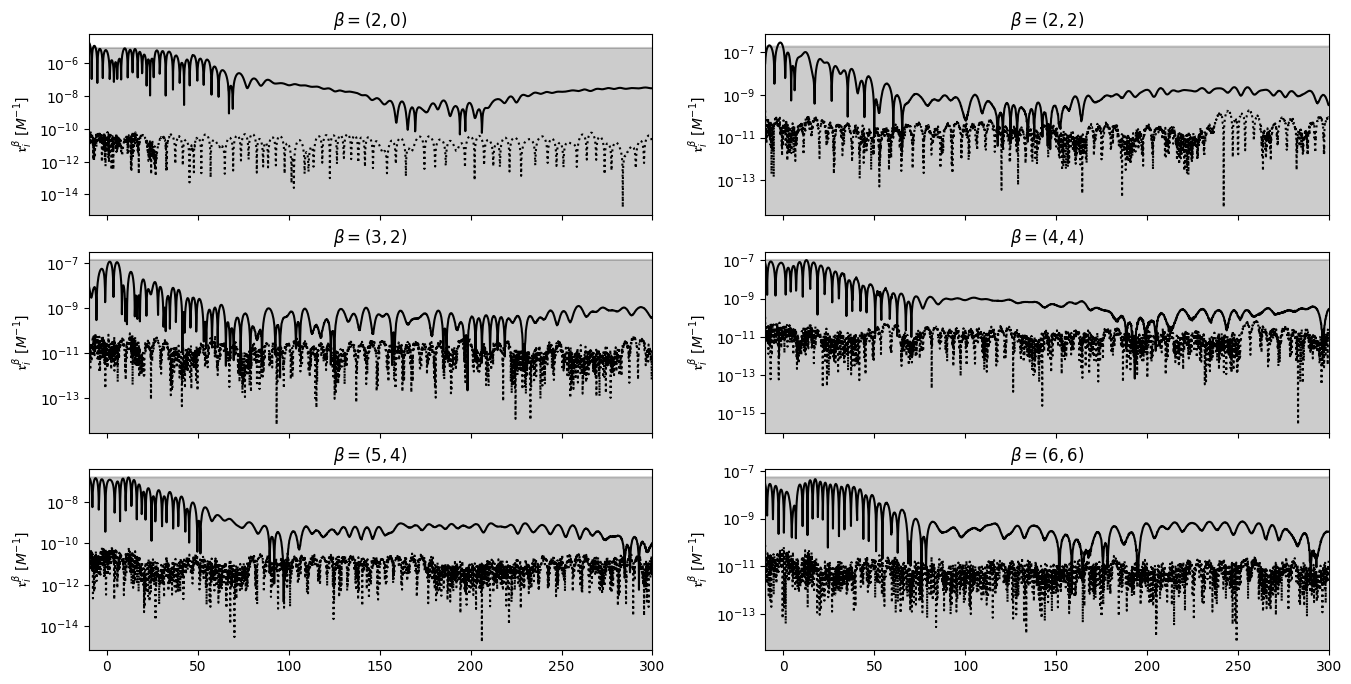

In [11]:
spherical_modes = [(2, 0), (2, 2), (3, 2), (4, 4), (5, 4), (6, 6)]

mask_big = (times >= RESIDUAL_BIG_START) & (times < RESIDUAL_BIG_START + RESIDUAL_BIG_END)
R_dict_big = {}
R_dict_big[sim_id] = {key: value[mask_big] for key, value in R_lm_big.items()}

tuned_params_lm = tuned_params[sim_id]

kernel_dict = {
    mode: bgp.compute_kernel_matrix(times, tuned_params_lm[mode], bgp.kernel_WN) for mode in spherical_modes
}

fig, axs = plt.subplots(3, 2, sharex=True, figsize=(16, 8))
axs = axs.flatten()

for i, (ell, m) in enumerate(spherical_modes):
    ax = axs[i]
    ax.plot(
        times,
        np.abs(np.real(R_dict_big[sim_id][ell, m])),
        color='k',
    )
    ax.plot(
        times,
        np.abs(np.imag(R_dict_big[sim_id][ell, m])),
        color='k',
        ls=":",
    )

    ax.fill_between(
        times,
        -np.sqrt(np.diag(kernel_dict[ell, m])),
        np.sqrt(np.diag(kernel_dict[ell, m])),
        color="k",
        alpha=0.2,
        edgecolor=None,
        label=r"1$\sigma$",
    )

    # TODO fix edge line

    ax.plot(times, np.sqrt(np.diag(kernel_dict[ell, m])), color="k", alpha=0.2)

    y_pos = 2e-5
    x_pos = 90

    ax.set_title(rf"$\beta = ({ell}, {m})$")
    ax.set_xlim(-10, 300)
    ax.set_ylabel(r"$\mathfrak{r}^{\beta}_{i} \,\, [M^{-1}]$")
    ax.set_yscale("log")
    # ax.set_ylim(1e-11, 3e-3)

In [75]:
t0 = 150 
T = 300
INCLUDE_CHIF = False
INCLUDE_MF = False
DATA_TYPE = 'news'
modes = [(2,0,0,1)] 
sph_modes = [(2,0)]
PLT_modes = [(2,0)]

A = 8.355621e-06 ± 2.244138e-08
t_p = -8.017522 ± 4.246604
lambda = 3.068888 ± 0.060700


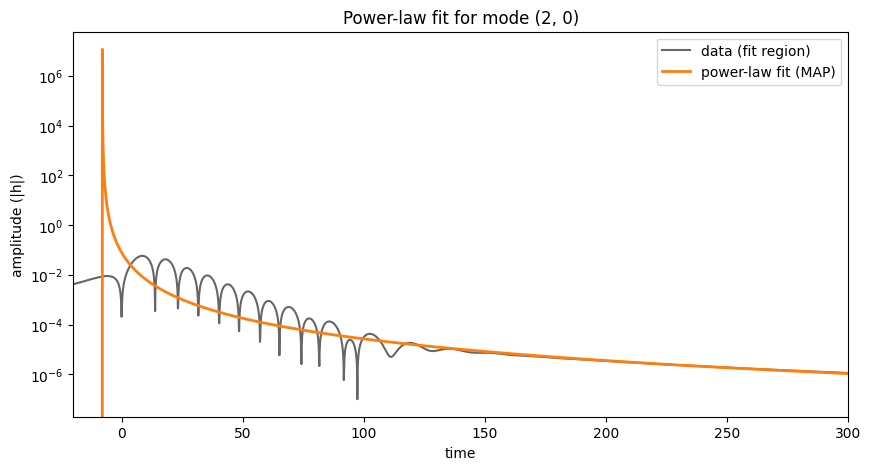

In [81]:
from scipy.optimize import curve_fit    

t = sim_main_new.times
mode = (2, 0)
h_mode = sim_main_new.h[mode]
amp = np.abs(h_mode)
mask = (t > t0) & (t <= T+t0)
t_fit = t[mask]
amp_fit = amp[mask]

def power_law(t_vals, A, t_p, lam, t0_fixed):
    y = np.zeros_like(t_vals, dtype=float)
    mask_local = t_vals > t_p
    #y[mask_local] = A * ((t_vals[mask_local] - t_p) / (t0_fixed - t_p)) ** (-lam)
    y[mask_local] = A * ((t_vals[mask_local] - t_p) / (t0_fixed - t_p)) ** (-lam)
    return y

# wrapper for curve_fit with fixed t0
def pl_wrapper(t_vals, A, t_p, lam):
    return power_law(t_vals, A, t_p, lam, t0)

# initial guess and bounds
p0 = [np.median(amp_fit), 47.0, 4.0]
bounds = ([0.0, -300.0, 0.0], [np.inf, t0 - 1e-6, 100.0])

popt, pcov = curve_fit(pl_wrapper, t_fit, amp_fit, p0=p0, bounds=bounds, maxfev=20000)
A_fit, t_p_fit, lam_fit = popt
perr = np.sqrt(np.diag(pcov))

print(f"A = {A_fit:.6e} ± {perr[0]:.6e}")
print(f"t_p = {t_p_fit:.6f} ± {perr[1]:.6f}")
print(f"lambda = {lam_fit:.6f} ± {perr[2]:.6f}")

# build model over full t for plotting (linear space)
model_amp = power_law(t, A_fit, t_p_fit, lam_fit, t0)

plt.figure(figsize=(10,5))
plt.plot(t, amp, color="k", alpha=0.6, label="data (fit region)")
plt.plot(t, model_amp, color="C1", lw=2, label="power-law fit (MAP)")
plt.xlim(-20, 300)
plt.yscale("log")
plt.xlabel("time")
plt.ylabel("amplitude (|h|)")
plt.title(f"Power-law fit for mode {mode}")
plt.legend()
plt.show()

(-3.0, 0.0)

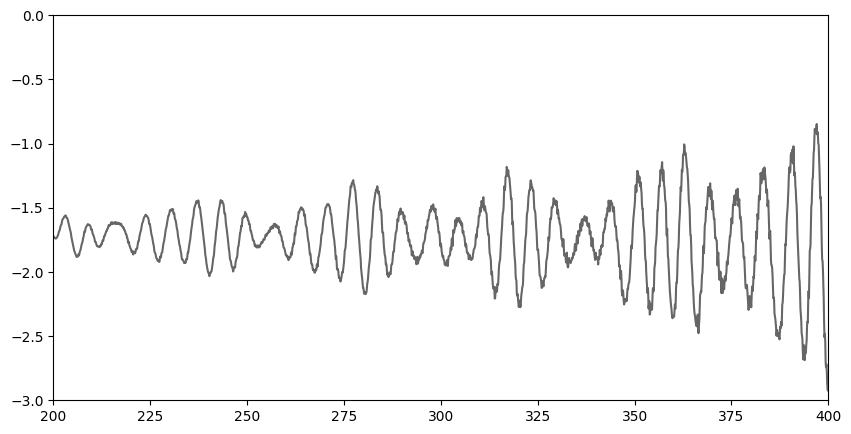

In [14]:
mode = (2, 0) 

mask = (sim_main_new.times >= 100) & (sim_main_new.times <= 400)
times_mask = sim_main_new.times[mask]
news_mask = np.abs(sim_main_new.h[mode][mask])

natural_log_news = np.log(news_mask)
natural_log_times = np.log(times_mask)

deriv = np.gradient(natural_log_news, natural_log_times)

plt.figure(figsize=(10,5))
plt.plot(times_mask, 1 + deriv, color="k", alpha=0.6, label="data")
plt.xlim(200, 400)
plt.ylim(-3, 0)

^ need a Savitzky-Golay filter!

In [15]:
h = sim_main_new.h[(2, 0)]
sim_main_new_filtered = h.copy()

mask = (sim_main_new.times >= 150) & (sim_main_new.times <= 400)
n_mask = mask.sum()

dt = np.mean(np.diff(sim_main_new.times))

real_f = savgol_filter(h.real[mask], 101, 1)
imag_f = savgol_filter(h.imag[mask], 101, 1)

sim_main_new_filtered[mask] = real_f + 1j * imag_f

(-3.0, 0.0)

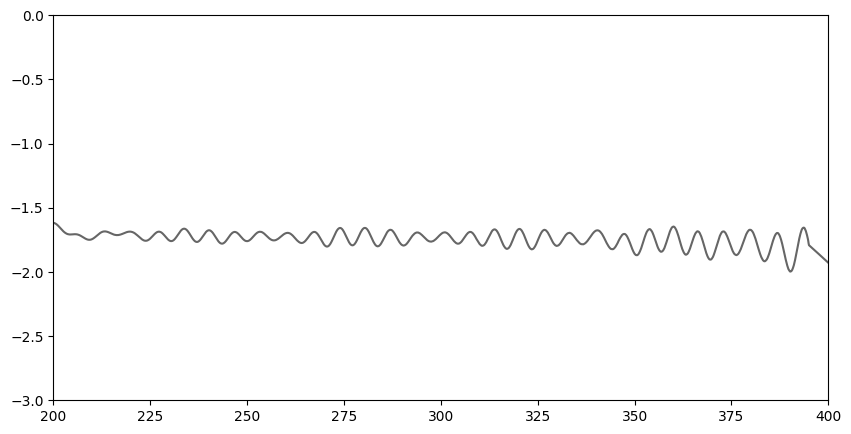

In [16]:
mode = (2, 0) 

mask = (sim_main_new.times >= 100) & (sim_main_new.times <= 400)
times_mask = sim_main_new.times[mask]
news_mask = np.abs(sim_main_new_filtered[mask])

natural_log_news = np.log(news_mask)
natural_log_times = np.log(times_mask)

deriv = np.gradient(natural_log_news, natural_log_times)

plt.figure(figsize=(10,5))
plt.plot(times_mask, 1 + deriv, color="k", alpha=0.6, label="data")
plt.xlim(200, 400)
plt.ylim(-3, 0)

In [ ]:
t0 = 100 
T = 300
INCLUDE_CHIF = False
INCLUDE_MF = False
DATA_TYPE = 'news'
modes = [(2,0,0,1)] 
sph_modes = [(2,0)]
PLT_modes = [(2,0)]

In [ ]:
fit = bgp.PLT_BGP_fit(
    sim_main_new.times,
    sim_main_new.h,
    modes,
    sim_main.Mf,
    sim_main.chif_mag,
    tuned_params[sim_id],
    bgp.kernel_WN,
    t0=t0,
    PLT_modes=PLT_modes,
    #lam_PLT_val = [lam_PLT],
    #t_PLT_val = [t_PLT],
    A_PLT_prior = (-1e-3, 1e-3),
    t_PLT_prior = (10, 20),
    lam_PLT_prior = (0, 5),
    nsteps=1000,
    nwalkers=20,
    T=T,
    spherical_modes=sph_modes,
    include_chif=INCLUDE_CHIF,
    include_Mf=INCLUDE_MF,
    data_type=DATA_TYPE
)

/data/vault/rvnd2/Code/bgp_qnm_fits/bgp_qnm_fits/base_fit.py:187: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(
100%|██████████| 5000/5000 [6:34:33<00:00,  4.73s/it]  


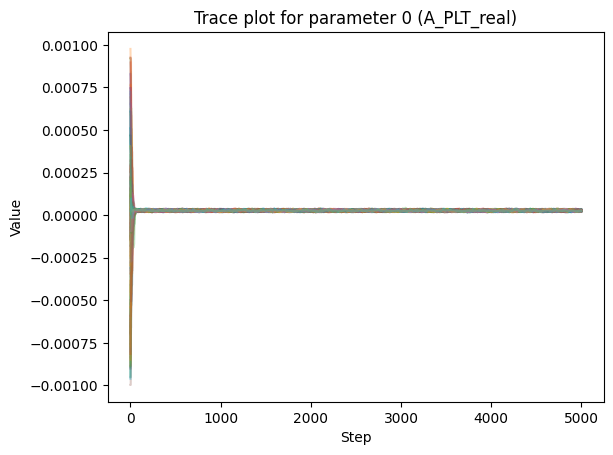

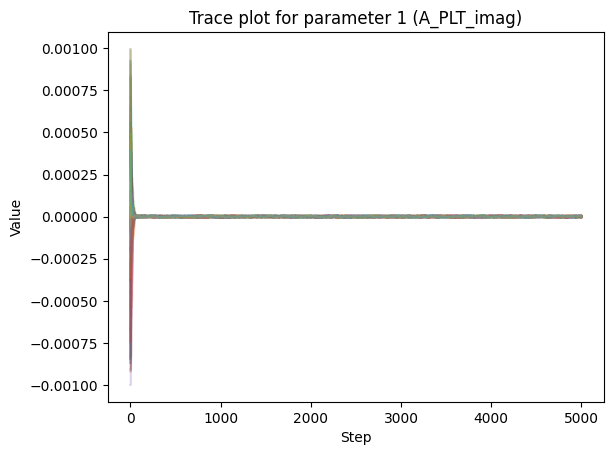

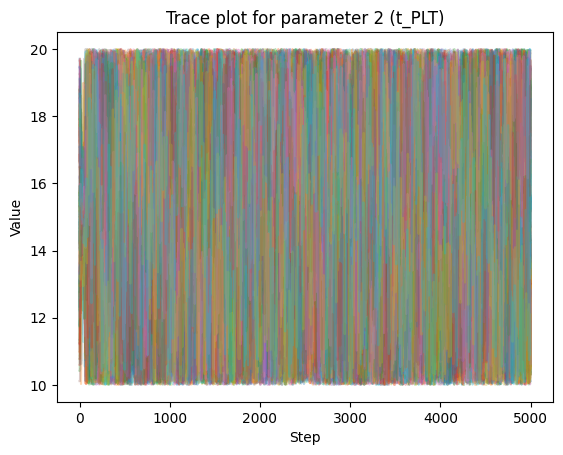

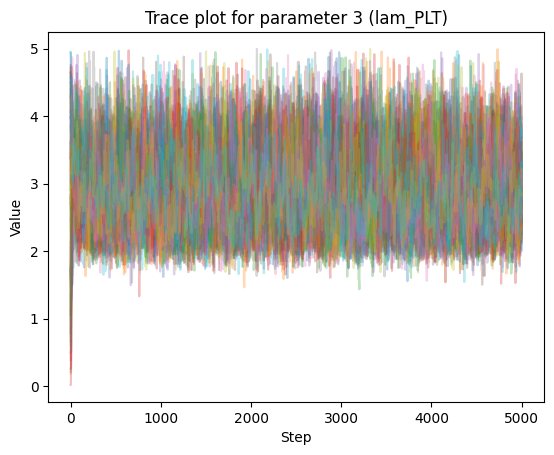

In [59]:
# mcmc_samples: shape (nsteps, nwalkers, ndim)
samples = fit.sampler.get_chain()  # shape: (nsteps, nwalkers, ndim)
param_names = ["A_PLT_real", "A_PLT_imag", "t_PLT", "lam_PLT"]   # Adjust as needed
#true_values = [A_PLT_real, A_PLT_imag, t_PLT]  # True values for reference

for i in range(4):
    plt.figure()
    for walker in range(samples.shape[1]):
        plt.plot(samples[:, walker, i], alpha=0.3)
    #plt.axhline(true_values[i], color='red', linestyle='--', label='True value')
    plt.title(f"Trace plot for parameter {i} ({param_names[i]})")
    plt.xlabel("Step")
    plt.ylabel("Value")
    plt.show()


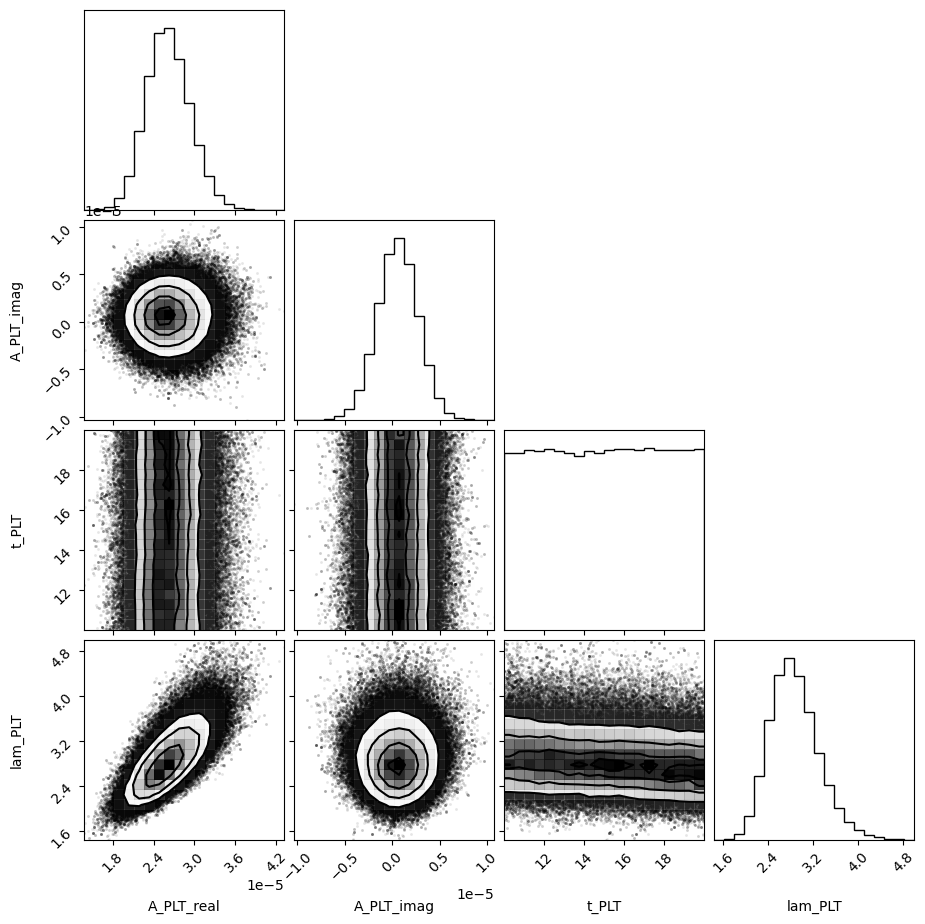

In [60]:
burn_in = int(0.2 * samples.shape[0])
flat_samples = fit.sampler.get_chain(discard=burn_in, flat=True)  
final_pos = samples[-1]

corner.corner(flat_samples, labels=param_names)
plt.show()

MAP parameters:
  A_PLT_real: 2.583227487371903e-05
  A_PLT_imag: 4.5721464480197483e-07
  t_PLT: 19.9438711664439
  lam_PLT: 2.6476340209749303


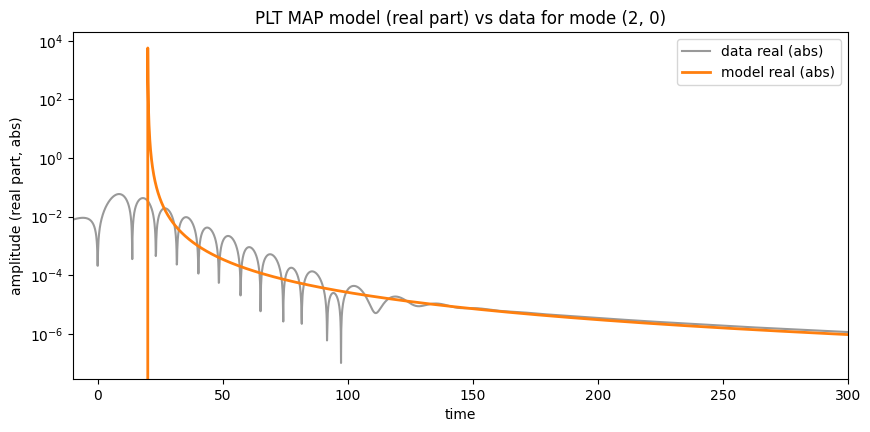

In [ ]:
# Determine MAP from the MCMC and plot the resulting PLT model against the data
# (only show the real part of the model)

# compute burn-in if not present (recompute harmlessly)
burn_in = int(0.2 * samples.shape[0])

# flatten chain after burn-in
flat = fit.sampler.get_chain(discard=burn_in, flat=True)

# try to get log-probabilities to pick the MAP sample; fallback to the sample closest to the mean
try:
    logp = fit.sampler.get_log_prob(discard=burn_in, flat=True)
    map_idx = np.argmax(logp)
except Exception:
    map_idx = np.argmin(np.sum((flat - np.mean(flat, axis=0)) ** 2, axis=1))

map_params = flat[map_idx]

print("MAP parameters:")
for name, val in zip(param_names, map_params):
    print(f"  {name}: {val}")

# build PLT model from MAP params (assumes order: A_real, A_imag, t_p, lam)
A_map_real = map_params[0]      # use only the real part of the amplitude
t_p_map = map_params[2]
lam_map = map_params[3]

t = sim_main.times
# construct real PLT model (zero before t_p_map)
plt_model_real = np.zeros_like(t, dtype=float)
mask_model = t > t_p_map
plt_model_real[mask_model] = A_map_real * ((t[mask_model] - t_p_map) / (t0 - t_p_map)) ** (-lam_map)

# choose the PLT mode(s) to compare (use PLT_modes defined earlier)
for mode in PLT_modes:
    data_mode = sim_main_new.h[mode]

    plt.figure(figsize=(10, 4.5))
    # plot only the real part (use absolute for log-scale compatibility)
    plt.plot(t, np.abs(data_mode.real), color="0.6", label="data real (abs)")
    plt.plot(t, np.abs(plt_model_real), color="C1", lw=2, label="model real (abs)")

    plt.yscale("log")
    plt.xlim(max(t.min(), -10), min(t.max(), 300))
    plt.xlabel("time")
    plt.ylabel("amplitude (real part, abs)")
    plt.title(f"PLT MAP model (real part) vs data for mode {mode}")
    plt.legend()
    plt.show()
    

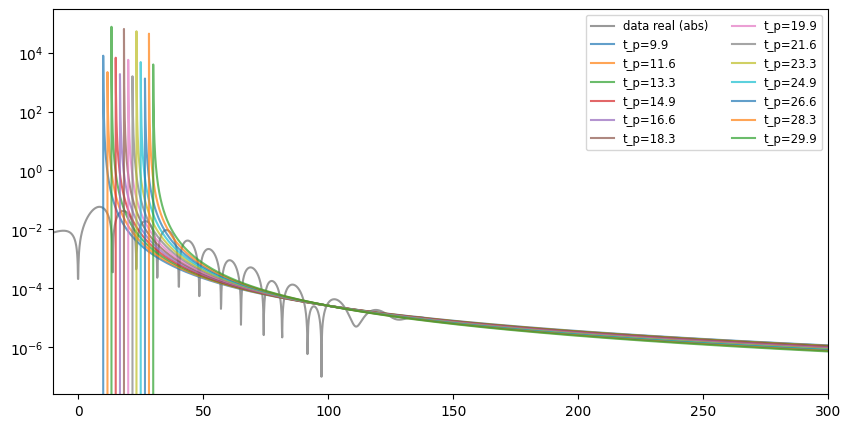

In [66]:
tp_span = 10.0
n_models = 13

tp_vals = np.linspace(t_p_map - tp_span, t_p_map + tp_span, n_models)
tp_vals = tp_vals[tp_vals < (t0 - 1e-6)]

t = sim_main_new.times
mode = (2, 0)

plt.figure(figsize=(10,5))
plt.plot(t, np.abs(sim_main_new.h[mode].real), color="0.6", label="data real (abs)")

for tp in tp_vals:
    model = np.zeros_like(t, dtype=float)
    mask_model = t > tp
    model[mask_model] = A_map_real * ((t[mask_model] - tp) / (t0 - tp)) ** (-lam_map)
    plt.plot(t, model, lw=1.5, alpha=0.7, label=f"t_p={tp:.1f}")

plt.xlim(max(t.min(), -10), min(t.max(), 300))
plt.yscale("log")
plt.legend(ncol=2, fontsize="small")
plt.show()

In [62]:
A_map_real_array = np.array([A_map_real])
A_map_imag_array = np.array([0])    
t_p_map_array = np.array([t_p_map])
lam_map_array = np.array([lam_map])

model = fit.get_full_model_linear(fit.constant_term, fit.mean_vector, fit.ref_params, fit.model_terms, 
                              fit.PLT_mode_indices, fit.analysis_times, 
                              A_map_real_array, A_map_imag_array, t_p_map_array, lam_map_array)

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


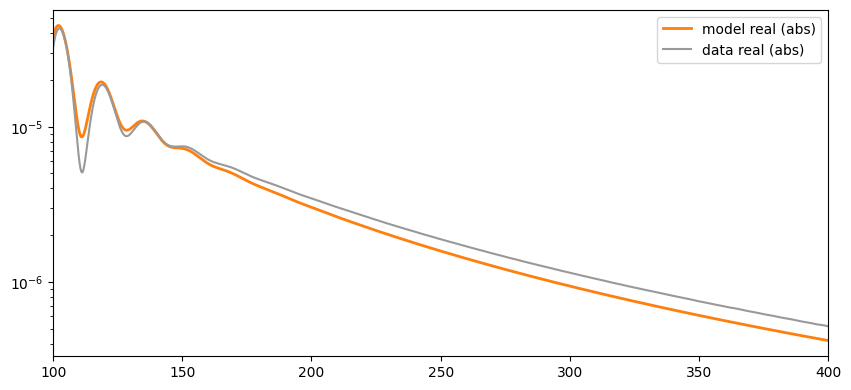

In [63]:
plt.figure(figsize=(10, 4.5))
plt.plot(fit.analysis_times, np.abs(model[0].real), color="C1", lw=2, label="model real (abs)")
plt.plot(fit.analysis_times, np.abs(fit.masked_data_array[0].real), color="0.6", label="data real (abs)")

plt.yscale("log")
plt.xlim(t0, t0+T)
plt.legend()
plt.show()